In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time
from dask.distributed import Client
import core as core

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Get a list of all years and months in those years to process
# Pass a list or a range, remember ranges are closed on the right side
# so to get all months range(1, 12+1 )

def get_file_paths(years: list[int], months: list[int] = range(1, 12+1)):
    path = "~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/"
    files = []
    files = [f"era5-{year}-{month:02}.nc" for year in years for month in months]
    files_path = [path+f for f in files]
    # print(f"Load data for {years=} {months=}")
    return files_path


In [3]:
from pathlib import Path
home = Path.home()
dask_workspace = home / "daskWorkspace"


def dask_compute(xarray, workers=20, threads=4):
    # Using Dask Client as a context manager
    with Client(n_workers=workers, threads_per_worker=threads, local_directory=dask_workspace) as client:
        print(client)
        start_time = time.time()
        pvpot = xarray.compute()
        end_time = time.time()
        execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.5f} seconds")
    return pvpot

In [4]:
def open_dataset(years: list[int] = [2000], months: list[int] = range(1, 12 + 1)):
    files_path = get_file_paths(years, months)
    ds = xr.open_mfdataset(files_path, engine="h5netcdf", chunks={"valid_time": 1e5})
    # ds=xr.open_mfdataset(files_path, engine="netcdf4", chunks={"valid_time":1e5} )
    ds["wspd"] = core.windspeed(ds)
    return ds


def filter_europe_box(ds):
    # Xarray seems to only allow increasing latitudes
    # So we have to make two separate cuts west and east of greenwich
    # and append the west as negatives

    # Cut the western part
    ds_west_eu = ds.sel(latitude=slice(70, 35)).sel(longitude=slice(350, 359.9))
    ds_west_eu['longitude'] = ds_west_eu['longitude'] - 360

    # Cut the eastern part
    ds_east_eu = ds.sel(latitude=slice(70, 35)).sel(longitude=slice(0, 30))

    ds_eu = xr.concat([ds_west_eu, ds_east_eu], dim="longitude")
    return ds_eu



In [5]:
# Open dataset and filter for europe
ds = open_dataset(months=range(1,12+1))
ds_eu = filter_europe_box(ds)

In [6]:
# Main pvpot calculation and grouping
pvpot_pre = core.pv_pot(ds_eu).groupby(ds_eu.valid_time.dt.month).mean("valid_time")

In [7]:
# Do the proper computation
pvpot = dask_compute(pvpot_pre)

<Client: 'tcp://127.0.0.1:33865' processes=20 threads=80, memory=753.83 GiB>
Execution time: 13.35419 seconds


In [8]:
print(f"""Calculated pvpot:
    Shape: {pvpot.shape}
    Months: {pvpot.shape[0]}
    Min: {pvpot.min().values}
    Mean: {pvpot.mean().values}
    Max: {pvpot.max().values}
    Std: {pvpot.std().values}
""")

Calculated pvpot:
    Shape: (12, 141, 161)
    Months: 12
    Min: 0.0
    Mean: 0.13677674531936646
    Max: 0.32627660036087036
    Std: 0.0850083976984024



In [12]:
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_pvpot_per_month(pvpot, min = 0, max = 1):
    fig, axs = plt.subplots(3, 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    axs = axs.flatten()
    contours = []
    for m in range(len(pvpot)):
        axs[m].add_feature(cfeature.COASTLINE)

        contour = axs[m].contourf(pvpot[m].longitude, pvpot[m].latitude, pvpot[m], vmin=min, vmax=max)
        axs[m].set_title(f"{calendar.month_name[m+1]}")
        contours.append(contour)
    fig.colorbar(cm.ScalarMappable(norm=Normalize(min, max)), ax=axs, orientation='vertical')


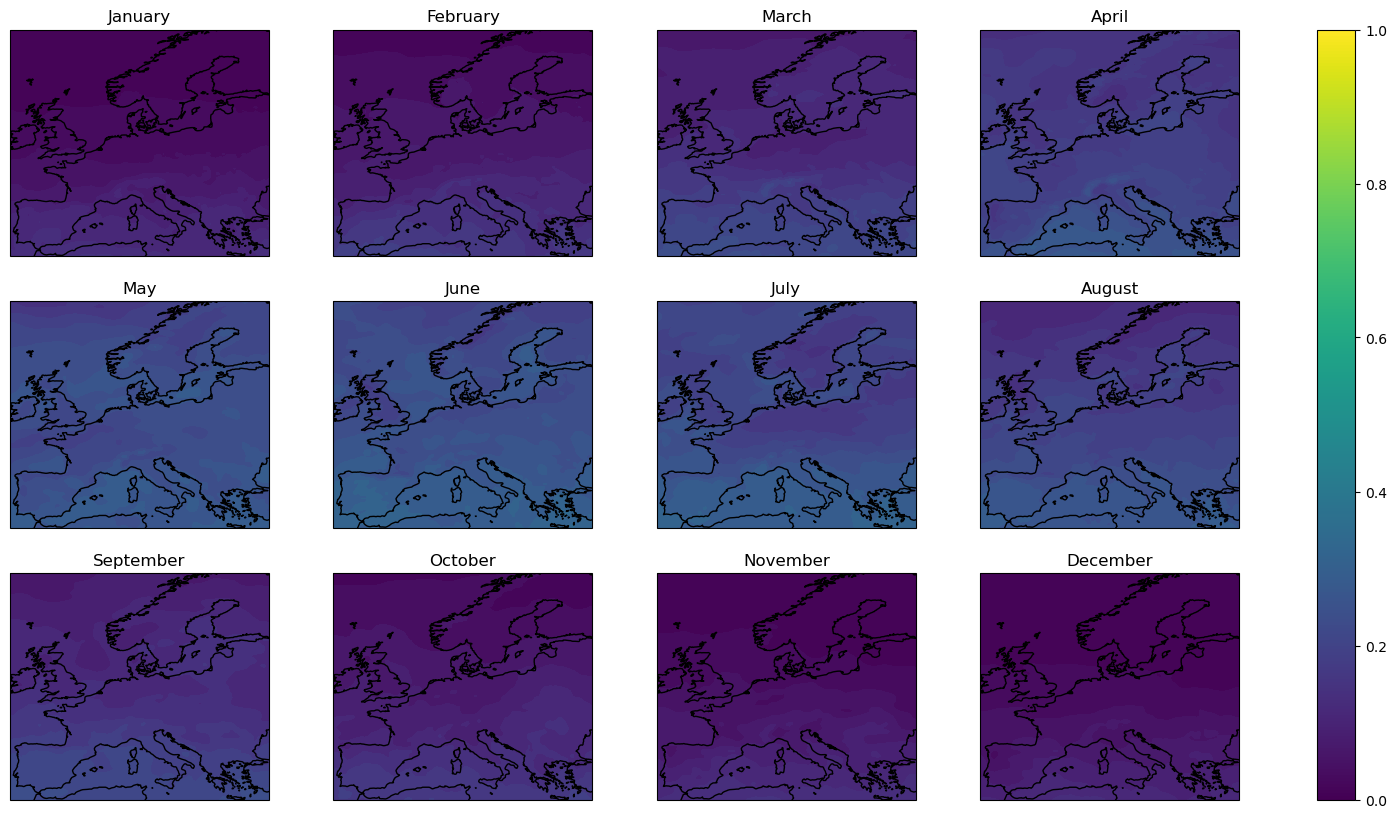

In [13]:
plot_pvpot_per_month(pvpot, min=0, max=1)